In [1]:
%reload_ext autoreload
%autoreload 2

# **Data Preparation**

In [2]:
from Ecommerce_Analytics.utils.paths import data_raw_dir, data_interim_dir
import Ecommerce_Analytics.plot as plots
import pandas as pd

## **Data Cleaning**

El conjunto de datos fue obtenido de la sección Real World Projects de DataCamp, donde se presenta como caso de estudio bajo el nombre Case Study: Ecommerce Analysis in Power BI.

[Enlace al curso en DataCamp](https://app.datacamp.com/learn/courses/case-study-ecommerce-analysis-in-power-bi)

En la sección de recursos del caso se encuentran disponibles los archivos con ejercicios, datasets y metadatos:

### **Exercises and Datasets**

[Enlace al PDF de Exercises and Datasets](https://assets.datacamp.com/production/repositories/6373/datasets/dd3112786b7aabfcdb7c4bdd451953d4736482e8/Case%20Study_%20Ecommerce%20Analysis%20in%20Power%20BI%20-%20Exercises%20and%20Datasets.pdf)

### **Metadata Sheet**

[Enlace al PDF de Metadata](https://assets.datacamp.com/production/repositories/6373/datasets/1cf007399125c429010598132d5c81a2ac66aa07/Metadata%20-%20Case%20study_%20Ecommerce%20Analysis%20in%20Power%20BI.pdf)

El conjunto está compuesto por 4 archivos CSV: ``customer.csv``, ``product.csv`` y ``state.csv`` corresponden a las dimensiones, y ``sale.csv`` representa la tabla de hechos. Las tablas contienen las siguientes columnas:

#### **Customer**

- **customer_id**: Customer unique identifier
- **order_city**: City
- **order_postal**: Postal code
- **order_state**: State
- **latitude**:  Latitude of customer location
- **longitude**: Longitude of customer location

#### **Product**

- **stock_code**: Product code
- **weight**: Weight of a single unit
- **landed_cost**: Manufacturer cost + freight
- **shipping_cost_1000_mile**: Average cost of shipping 1000 miles to customers
- **description**: Most recent product description
- **category**: Product category

#### **State**

- **order_state**: State code, description and all its variations
- **state_abbreviation**: The full name of the state
- **region**: Region name
- **state**: A standardized state code

#### **Sale**

- **transaction_date**: Date of purchase
- **customer_id**: Customer identifier
- **description**: Product description
- **stock_code**: Product code
- **invoice_no**: An invoice contains multiple products and represents a single checkout
- **quantity**: Quantity of a product purchased
- **sale**: Total amount of a product in a single checkout
- **unit_price**: Unit price of a product

#### **Customer Table Preparation**

In [3]:
raw_data_path = data_raw_dir("customer.csv")
customer_df = pd.read_csv(raw_data_path, encoding="utf-8")
customer_df.head()

,customer_id,order_city,order_postal,order_state,latitude,longitude
0,18287,Rock Springs,82901-7321,WY,41.5869,-109.2048
1,18283,JACKSON,83001-9460,WY,43.4800,-110.7618
2,18282,Greybull,82426,WY,44.4892,-108.0562
3,18281,EVANSTON,82930-4706,WY,41.2680,-110.9633
4,18280,CHEYENNE,82001-7901,WY,41.1400,-104.8202


Se cargó el archivo customer.csv en el dataframe customer_df. La inspección visual del encabezado reveló que las columnas order_city y order_postal presentan formatos inconsistentes. La primera, en particular, mezcla mayúsculas y minúsculas, lo que indica la necesidad de estandarización para evitar duplicados.

In [4]:
raw_data_path = data_raw_dir("state.csv")
state_df = pd.read_csv(raw_data_path, encoding="utf-8")
state_df.head()

,order_state,state_abbreviation,region,state
0,AE,AE,Other,Armed Forces Europe
1,ak,AK,Other,Alaska
2,AK,AK,Other,Alaska
3,AL,AL,East,Alabama
4,ALABAMA,AL,East,Alabama


Se cargó el archivo state.csv en el dataframe state_df, el cual servirá como catálogo de referencia. Se encontró que la columna order_state tiene formatos variados, mientras que la columna state_abbreviation parece ser el formato estandarizado que se usará para corregir los datos de estado en la tabla de clientes.

In [5]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   customer_id   4372 non-null   int64  
 1   order_city    4372 non-null   object 
 2   order_postal  4372 non-null   object 
 3   order_state   4372 non-null   object 
 4   latitude      4282 non-null   float64
 5   longitude     4282 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 205.1+ KB


La verificación de customer_df reveló que las columnas latitude y longitude no están completas, ya que solo contienen 4,282 valores no nulos de un total de 4,372. Esta es una señal clara de que existen datos faltantes que deben ser tratados para futuros análisis geográficos.

      Column  Complete Values  Complete Data  Missing Values  Missing Data
 customer_id             4372           1.00               0          0.00
  order_city             4372           1.00               0          0.00
order_postal             4372           1.00               0          0.00
 order_state             4372           1.00               0          0.00
    latitude             4282           0.98              90          0.02
   longitude             4282           0.98              90          0.02


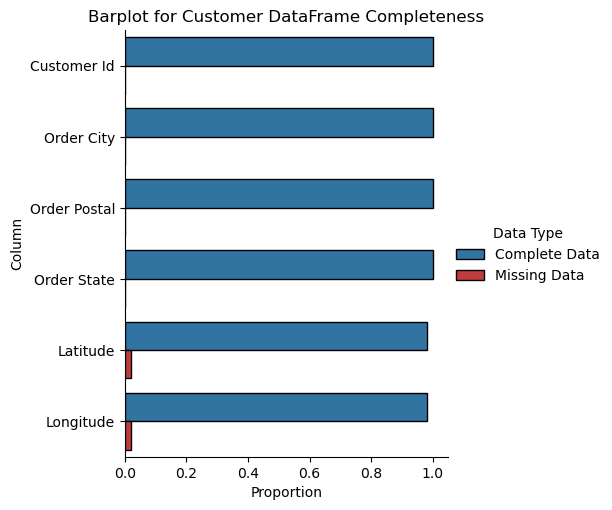

In [6]:
customer_df_columns = list(customer_df.columns)
plots.completeness_barplot(df=customer_df, columns=customer_df_columns, df_name="Customer")

El gráfico de barras de completitud revela que las columnas latitude y longitude tienen un 2% de datos faltantes, mientras que el resto de las columnas del dataframe customer_df están 100% completas. 

In [7]:
duplicated_rows = customer_df.duplicated(keep=False)
duplicated_rows_count = int(duplicated_rows.sum())
duplicated_rows_count

0

Se verificaron los registros duplicados en el dataframe customer_df. La consulta no arrojó resultados, lo que confirma que no hay filas duplicadas en la tabla. 

      Column  Unique Values
 customer_id           4372
  order_city           2657
order_postal           4239
 order_state            206
    latitude           2402
   longitude           2412


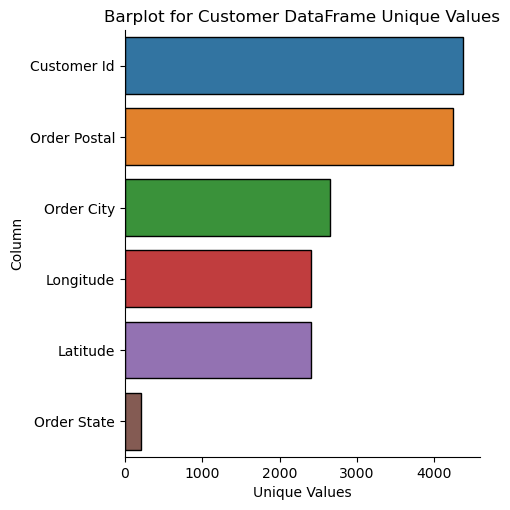

In [8]:
plots.uniqueness_barplot(df=customer_df, columns=customer_df_columns, df_name="Customer")

El gráfico de barras de valores únicos revela que las columnas order_city y order_postal tienen una alta cardinalidad. Por otro lado, order_state tiene un número de valores únicos muy bajo en comparación con el total de registros, lo que refuerza su rol como una categoría que se puede normalizar.

In [9]:
customer_df["order_state"].unique()

array(['WY', 'WV', 'Wisconsin', 'WI', 'wi', 'Wi', 'WEST VIRGINIA',
       'WASHINGTON', 'Washington', 'WA', 'wa', 'Wa', 'VT', 'VIRGINIA',
       'Virginia', 'VERMONT', 'Va.', 'VA', 'va', 'Va', 'UTAH', 'Utah',
       'UT', 'Tx', 'TX', 'tx', 'TN', 'tn', 'Texas', 'TEXAS', 'texas',
       'Tennessee', 'TENNESSEE', 'South Carolina', 'SOUTH CAROLINA', 'SD',
       'SC', 'sc', 'RI', 'ri', 'Rhode Island', 'RHODE ISLAND', 'ALASKA',
       'Alaska', 'Delaware', 'DE', 'Pennsylvania', 'PENNSYLVANIA', 'Pa.',
       'PA', 'Pa', 'pa', 'OREGON', 'Oregon', 'OR', 'or', 'Or', 'OKLAHOMA',
       'Oklahoma', 'OK', 'Ok', 'ok', 'Ohio', 'OHIO', 'OH', 'oh', 'NY',
       'ny', 'Ny', 'NV', 'North Carolina', 'NORTH CAROLINA', 'NM', 'NJ',
       'nj', 'Nj', 'NH', 'nh', 'NEW YORK', 'new york', 'New York',
       'New Mexico', 'NEW MEXICO', 'New Jersey', 'new jersey',
       'NEW JERSEY', 'New Hampshire', 'NEVADA', 'Nebraska', 'NE', 'Ne',
       'ND', 'NC', 'nc', 'N.Y.', 'N.C.', 'n.c.', 'MT', 'MS', 'MONTANA',
      

La inspección de los valores únicos en la columna order_state revela una falta de estandarización. Se observan variaciones en mayúsculas y minúsculas, nombres completos y abreviaturas para un mismo estado. 

In [10]:
state_df["order_state"] = state_df["order_state"].str.replace(r"[,.:;_\-]", "", regex=True).str.capitalize()
state_df["state"] = state_df["state"].str.replace(r"[,.:;_\-]", "", regex=True).str.capitalize()

customer_df["order_state"] = customer_df["order_state"].str.replace(r"[,.:;_\-]", "", regex=True).str.capitalize()
map1 = dict(state_df[["order_state", "state_abbreviation"]].drop_duplicates().values)
map2 = dict(state_df[["state", "state_abbreviation"]].drop_duplicates().values)
mapping = map1 | map2
customer_df["order_state"] = customer_df["order_state"].replace(mapping)

customer_df["order_state"].unique()

array(['WY', 'WV', 'WI', 'WA', 'VT', 'VA', 'UT', 'TX', 'TN', 'SC', 'SD',
       'RI', 'AK', 'DE', 'PA', 'OR', 'OK', 'OH', 'NY', 'NV', 'NC', 'NM',
       'NJ', 'NH', 'NE', 'ND', 'MT', 'MS', 'MO', 'MN', 'MI', 'ME', 'MD',
       'MA', 'LA', 'KY', 'KS', 'IA', 'IN', 'IL', 'ID', 'HI', 'GA', 'FL',
       'DC', 'CT', 'CO', 'CA', 'AZ', 'AR', 'AL'], dtype=object)

In [11]:
customer_df["order_state"] = customer_df["order_state"].astype("category")

La columna order_state se estandarizó para corregir las inconsistencias. Se utilizaron diccionarios de mapeo para reemplazar los valores variados con sus abreviaturas estandarizadas, garantizando que todos los estados ahora tengan un formato uniforme.

In [12]:
customer_df["order_city"].unique()

array(['Rock Springs', 'JACKSON', 'Greybull', ..., 'Kodiak', 'anchorage',
       'ANCHORAGE'], dtype=object)

La inspección de los valores únicos en la columna order_city revela una falta de estandarización. Se observan variaciones en mayúsculas y minúsculas para un mismo nombre de ciudad.

In [13]:
customer_df["order_city"] = customer_df["order_city"].replace(r"[,.:;_\-]", "", regex=True).str.capitalize()
customer_df["order_city"].unique()

array(['Rock springs', 'Jackson', 'Greybull', ..., 'Abbeville', 'Kodiak',
       'Anchorage'], dtype=object)

In [14]:
customer_df["order_city"] = customer_df["order_city"].astype("category")

Se estandarizaron los valores de la columna order_city al convertirlos a un formato de mayúscula inicial. Esto ayuda a eliminar duplicados y asegura que los nombres de las ciudades sean consistentes para el análisis.

In [15]:
duplicated_rows = customer_df.duplicated(keep=False)
duplicated_rows_count = int(duplicated_rows.sum())
duplicated_rows_count

0

In [16]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   customer_id   4372 non-null   int64   
 1   order_city    4372 non-null   category
 2   order_postal  4372 non-null   object  
 3   order_state   4372 non-null   category
 4   latitude      4282 non-null   float64 
 5   longitude     4282 non-null   float64 
dtypes: category(2), float64(2), int64(1), object(1)
memory usage: 233.9+ KB


El dataframe fue inspeccionado nuevamente después de la estandarización. Se confirmó que no hay registros duplicados. Adicionalmente, se verificó que las columnas order_city y order_state ahora tienen el tipo de dato category, lo que optimiza su uso y confirma el éxito del proceso de limpieza.

In [17]:
interim_data_path = data_interim_dir('customer.csv')
customer_df.to_csv(interim_data_path, index=False)

#### **State Table Preparation**

In [18]:
raw_data_path = data_raw_dir("state.csv")
state_df = pd.read_csv(raw_data_path, encoding="utf-8")
state_df.head()

,order_state,state_abbreviation,region,state
0,AE,AE,Other,Armed Forces Europe
1,ak,AK,Other,Alaska
2,AK,AK,Other,Alaska
3,AL,AL,East,Alabama
4,ALABAMA,AL,East,Alabama


In [19]:
state_df.drop(columns=["order_state"],inplace=True)
state_df.rename(columns={"state_abbreviation":"order_state"}, inplace=True)

In [20]:
state_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   order_state  192 non-null    object
 1   region       192 non-null    object
 2   state        192 non-null    object
dtypes: object(3)
memory usage: 4.6+ KB


El dataframe state_df fue normalizado al eliminar la columna order_state y renombrar state_abbreviation a order_state. La inspección posterior de la tabla confirmó que ahora tiene solo tres columnas y que todas están 100% completas, lo que valida que el proceso de limpieza y simplificación fue exitoso.

     Column  Complete Values  Complete Data  Missing Values  Missing Data
order_state              192            1.0               0           0.0
     region              192            1.0               0           0.0
      state              192            1.0               0           0.0


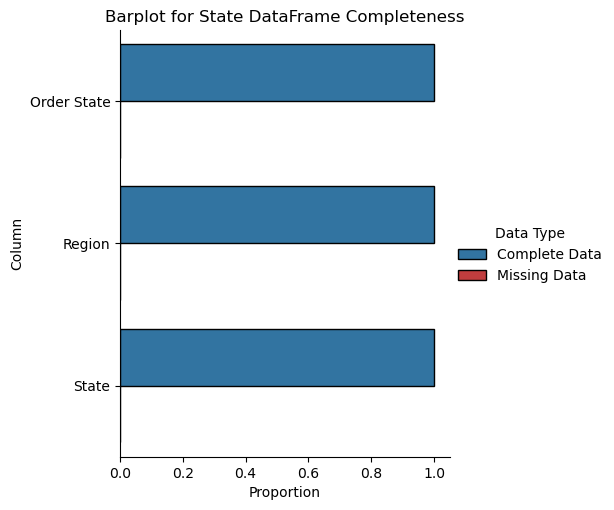

In [21]:
state_df_columns = list(state_df.columns)
plots.completeness_barplot(df=state_df, columns=state_df_columns, df_name="State")

El gráfico de barras de completitud confirma visualmente que el dataframe state_df no tiene ningún valor nulo.

In [22]:
duplicated_rows = state_df.duplicated(keep=False)
duplicated_rows_count = int(duplicated_rows.sum())
duplicated_rows_count                   

184

In [23]:
state_df[duplicated_rows].head()

,order_state,region,state
1,AK,Other,Alaska
2,AK,Other,Alaska
3,AL,East,Alabama
4,AL,East,Alabama
5,AK,Other,Alaska


In [24]:
state_df.drop_duplicates(inplace=True)

La inspección de duplicados en el dataframe state_df reveló la presencia de filas idénticas. Estas duplicidades se originaron por la eliminación de la columna order_state que contenía datos inconsistentes, lo que expuso registros idénticos. El siguiente paso fue eliminar estas filas para garantizar que cada estado tenga un registro único.

     Column  Unique Values
order_state             54
     region              4
      state             54


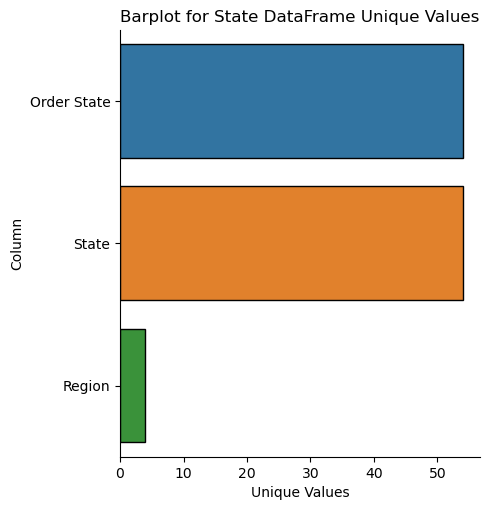

In [25]:
plots.uniqueness_barplot(df=state_df, columns=state_df_columns, df_name="State")

El gráfico de barras de valores únicos muestra que order_state y state tienen 54 valores únicos, lo cual es lo esperado. La columna region solo tiene 4 valores únicos, lo que la convierte en una variable categórica ideal para análisis de segmentación.

In [26]:
state_df["state"].unique()

array(['Armed Forces Europe', 'Alaska', 'Alabama', 'Arkansas', 'Arizona',
       'California', 'Colorado', 'Connecticut', 'District of Columbia',
       'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Iowa', 'Idaho',
       'Illinois', 'Indiana', 'Kansas', 'Kentucky', 'Louisiana',
       'Massachusetts', 'Maine', 'Maryland', 'Michigan', 'Minnesota',
       'Missouri', 'Montana', 'Mississippi', 'North Carolina', 'New York',
       'North Dakota', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Virgin Islands', 'Utah',
       'Virginia', 'Vermont', 'Washington', 'West Virginia', 'Wisconsin',
       'Wyoming'], dtype=object)

In [27]:
state_df["state"] = state_df["state"].astype("category")

In [28]:
state_df["region"].unique()

array(['Other', 'East', 'Central', 'West'], dtype=object)

In [29]:
state_df["region"] = state_df["region"].astype("category")

In [30]:
state_df["order_state"].unique()

array(['AE', 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'ME',
       'MD', 'MI', 'MN', 'MO', 'MT', 'MS', 'NC', 'NY', 'ND', 'NE', 'NV',
       'NH', 'NJ', 'NM', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD',
       'TN', 'TX', 'VI', 'UT', 'VA', 'VT', 'WA', 'WV', 'WI', 'WY'],
      dtype=object)

In [31]:
state_df["order_state"] = state_df["order_state"].astype("category")

La inspección de los valores únicos en las columnas state, region y order_state revelaron que no hay inconsistencias. La columnas se convirtieron a tipo de dato category para asegurar que los datos estén listos para el análisis.

In [32]:
state_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54 entries, 0 to 191
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   order_state  54 non-null     category
 1   region       54 non-null     category
 2   state        54 non-null     category
dtypes: category(3)
memory usage: 5.7 KB


In [33]:
duplicated_rows = state_df.duplicated(keep=False)
duplicated_rows_count = int(duplicated_rows.sum())
duplicated_rows_count

0

El dataframe fue inspeccionado después del proceso de limpieza. Se confirmó que todas las columnas order_state, region y state están 100% completas y que no existen registros duplicados.

In [34]:
interim_data_path = data_interim_dir("state.csv")
state_df.to_csv(interim_data_path, index=False)

#### **Product Table Preparation**

In [35]:
raw_data_path = data_raw_dir("product.csv")
product_df = pd.read_csv(raw_data_path, encoding="utf-8")
product_df.head()

,stock_code,weight,landed_cost,shipping_cost_1000_mile,description,category
0,22423,40.0,35.0,20.0,Taste of the Wild High Prairie Grain-Free Dry ...,Food
1,85123A,2.0,6.0,5.0,Dog and Puppy Pads,Disposables
2,47566,6.0,18.0,12.0,"Memory Foam Pet Beds for Small, Medium, and La...",Disposables
3,85099B,2.0,5.0,4.0,Earth Rated Dog Poop Bags,Disposables
4,23084,2.0,6.0,6.0,Templation Soft Cat Treats,Pet Food


La carga del archivo product.csv en el dataframe product_df reveló que la columna stock_code presenta un formato inconsistente. Se observan variaciones donde algunos valores terminan en una letra, lo que indica la necesidad de estandarización para asegurar la uniformidad de los datos.

In [36]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   stock_code               20 non-null     object 
 1   weight                   20 non-null     float64
 2   landed_cost              20 non-null     float64
 3   shipping_cost_1000_mile  20 non-null     float64
 4   description              20 non-null     object 
 5   category                 20 non-null     object 
dtypes: float64(3), object(3)
memory usage: 1.1+ KB


La inspección de la información del dataframe product_df confirmó que no hay valores nulos y que todas las columnas contienen 20 registros. 

                 Column  Complete Values  Complete Data  Missing Values  Missing Data
             stock_code               20            1.0               0           0.0
                 weight               20            1.0               0           0.0
            landed_cost               20            1.0               0           0.0
shipping_cost_1000_mile               20            1.0               0           0.0
            description               20            1.0               0           0.0
               category               20            1.0               0           0.0


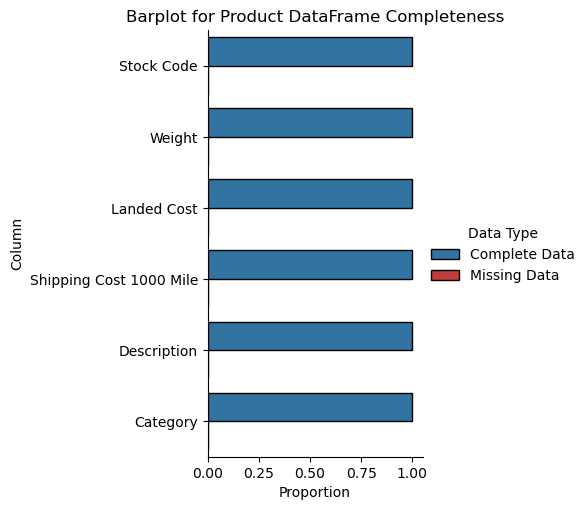

In [37]:
product_df_columns = list(product_df.columns)
plots.completeness_barplot(df=product_df, columns=product_df_columns, df_name="Product")

El gráfico de barras de completitud confirma que el dataframe product_df no tiene ningún valor nulo, ya que todas las columnas tienen una proporción de 1.0 de datos completos. 

In [38]:
duplicated_rows = product_df.duplicated(keep=False)
duplicated_rows_count = int(duplicated_rows.sum())
duplicated_rows_count

0

La verificación de duplicados en el dataframe product_df confirmó que no hay registros duplicados.

                 Column  Unique Values
             stock_code             20
                 weight              9
            landed_cost             15
shipping_cost_1000_mile              9
            description             20
               category              7


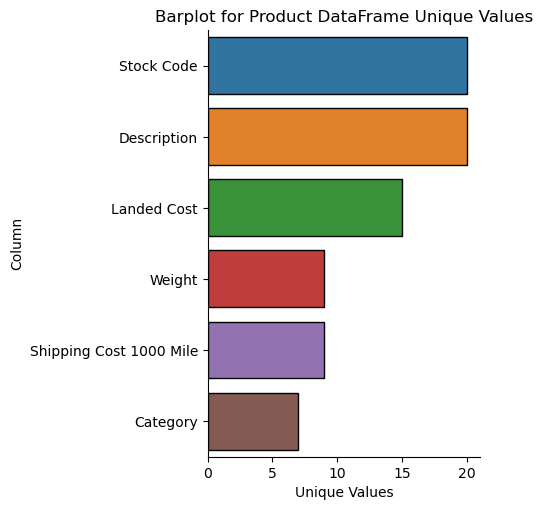

In [39]:
plots.uniqueness_barplot(df=product_df, columns=product_df_columns, df_name="Product")

El análisis de valores únicos confirma que las columnas stock_code y description tienen 20 valores únicos. Las columnas weight, landed_cost, shipping_cost_1000_mile y category tienen valores que se repiten, lo que las convierte en candidatas ideales para análisis de segmentación.

In [40]:
product_df["stock_code"].unique()

array(['22423', '85123A', '47566', '85099B', '23084', '22086', '84879',
       '79321', '22502', '22197', '23298', '22386', '23203', '21137',
       '22720', '23284', '22960', '82484', '20725', '22114'], dtype=object)

La inspección de los valores únicos en la columna stock_code confirmó la inconsistencia previamente identificada. Se observan valores que terminan en letras, lo que requerirá una limpieza para estandarizar el formato de los códigos.

In [41]:
product_df["category"].unique()

array(['Food', 'Disposables', 'Pet Food', 'Cleanig Supplies',
       'Supplements', 'Electronics', 'Grooming'], dtype=object)

In [42]:
product_df["category"] = product_df["category"].str.replace("Cleanig", "Cleaning")
product_df["category"] = product_df["category"].astype("category")

In [43]:
product_df["description"].unique()

array(['Taste of the Wild High Prairie Grain-Free Dry Dog Food 40lb',
       'Dog and Puppy Pads',
       'Memory Foam Pet Beds for Small, Medium, and Large Dogs and Cats',
       'Earth Rated Dog Poop Bags', 'Templation Soft Cat Treats',
       'Litter Slide Multi-Cat Scented Clumping Clay Cat Litter',
       'Pet Odor Eliminator', 'ProBiotic Supplements for Dogs',
       'Indoor Pet Camera', 'Sheba Perfect Portions Pat� Wet Cat Food',
       'Purina ONE SmartBlend Natural Adult Chicken 10lb',
       'Milk-Bone MaroSnacks Dog Treats with Real Bone',
       'Pet Hair Remover', 'Canned Cat Food',
       'UltraSound Dog Barking Deterrent',
       'Purina Pro Plan Adult Sensitive Skin',
       'Rechargeable Pet Nail Grinder', 'NexGard Chew for Dogs',
       'Pet Grooming Brush',
       'ChomChom Pet Hair Remover - Reusable Cat and Dog Hair Remover'],
      dtype=object)

In [44]:
product_df["description"] = product_df["description"].str.replace("�", "")
product_df["description"] = product_df["description"].astype("category")
product_df.rename(columns={"description": "product_description"}, inplace=True)

La inspección de los valores únicos en las columnas category y description no reveló mayores inconsistencias. Dadas sus características de valores finitos y únicos por registro, se convirtieron a tipo de dato category y se renombró description a product_description para asegurar que los datos estén listos para un análisis eficiente.

In [45]:
inconsistent_rows = product_df["shipping_cost_1000_mile"] <= 0
inconsistent_rows_count = int(inconsistent_rows.sum())
inconsistent_rows_count

0

In [46]:
inconsistent_rows = product_df["landed_cost"] <= 0
inconsistent_rows_count = int(inconsistent_rows.sum())
inconsistent_rows_count

0

In [47]:
inconsistent_rows = product_df["weight"] <= 0
inconsistent_rows_count = int(inconsistent_rows.sum())
inconsistent_rows_count

0

Se validaron las columnas numéricas shipping_cost_1000_mile, landed_cost y weight para detectar valores inconsistentes (valores iguales o menores a cero). La inspección confirmó que todas las columnas son consistentes y no tienen valores nulos, lo que significa que los datos están listos para ser utilizados en modelos o análisis de costos.

In [48]:
inconsistent_rows = product_df["stock_code"].str.isdigit() == False
inconsistent_rows_count = int(inconsistent_rows.sum())
inconsistent_rows_count

2

In [49]:
product_df[inconsistent_rows].head()

,stock_code,weight,landed_cost,shipping_cost_1000_mile,product_description,category
1,85123A,2.0,6.0,5.0,Dog and Puppy Pads,Disposables
3,85099B,2.0,5.0,4.0,Earth Rated Dog Poop Bags,Disposables


In [50]:
product_df["stock_code"] = product_df["stock_code"].str.replace(r"\D", "", regex=True)
product_df[inconsistent_rows].head()

,stock_code,weight,landed_cost,shipping_cost_1000_mile,product_description,category
1,85123,2.0,6.0,5.0,Dog and Puppy Pads,Disposables
3,85099,2.0,5.0,4.0,Earth Rated Dog Poop Bags,Disposables


In [51]:
product_df["stock_code"] = product_df["stock_code"].astype("int")

Se identificaron y corrigieron los valores inconsistentes en la columna stock_code al eliminar las letras al final de los códigos. Esto aseguró la uniformidad de los datos, permitiendo que la columna se convirtiera al tipo de dato entero para futuras operaciones y análisis numéricos.

In [52]:
duplicated_rows = product_df.duplicated(keep=False)
duplicated_rows_count = int(duplicated_rows.sum())
duplicated_rows_count

0

In [53]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   stock_code               20 non-null     int64   
 1   weight                   20 non-null     float64 
 2   landed_cost              20 non-null     float64 
 3   shipping_cost_1000_mile  20 non-null     float64 
 4   product_description      20 non-null     category
 5   category                 20 non-null     category
dtypes: category(2), float64(3), int64(1)
memory usage: 1.8 KB


El dataframe fue inspeccionado nuevamente tras la limpieza. Se confirmó que no se generaron duplicados y que la columna stock_code ahora es de tipo de dato int, lo que valida que el proceso de estandarización fue exitoso.

In [54]:
interim_data_path = data_interim_dir("product.csv")
product_df.to_csv(interim_data_path, index=False)

#### **Sale Table Preparation**

In [55]:
raw_data_path = data_raw_dir("sale.csv")
sale_df = pd.read_csv(raw_data_path, encoding="utf-8")
sale_df.head()

,transaction_date,customer_id,description,stock_code,invoice_no,quantity,sale,unit_price
0,12/1/2020 8:26,17850.0,Dog and Puppy Pads,85123A,536365.0,1,15.30,15.30
1,12/1/2020 8:34,13047.0,Pet Odor Eliminator,84879,536367.0,6,60.84,10.14
2,12/1/2020 8:34,13047.0,Rechargeable Pet Nail Grinder,22960,536368.0,1,25.50,25.50
3,12/1/2020 9:00,13748.0,Litter Slide Multi-Cat Scented Clumping Clay C...,22086,536371.0,14,214.20,15.30
4,12/1/2020 9:02,17850.0,Dog and Puppy Pads,85123A,536373.0,1,15.30,15.30


La carga del archivo sale.csv crea el dataframe sale_df. La inspección visual del encabezado reveló una inconsistencia en la columna stock_code, ya que algunos valores terminan en letras. Esto indica la necesidad de estandarizar el formato de los datos.

In [56]:
sale_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25065 entries, 0 to 25064
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_date  25065 non-null  object 
 1   customer_id       20649 non-null  float64
 2   description       25065 non-null  object 
 3   stock_code        25065 non-null  object 
 4   invoice_no        24404 non-null  float64
 5   quantity          25065 non-null  int64  
 6   sale              25065 non-null  float64
 7   unit_price        25065 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 1.5+ MB


La inspección inicial del dataframe sale_df reveló la presencia de valores nulos y tipos de datos inconsistentes. En particular, las columnas customer_id y invoice_no contienen valores faltantes, lo que requiere una limpieza profunda para su posterior uso en análisis.

          Column  Complete Values  Complete Data  Missing Values  Missing Data
transaction_date            25065           1.00               0          0.00
     customer_id            20649           0.82            4416          0.18
     description            25065           1.00               0          0.00
      stock_code            25065           1.00               0          0.00
      invoice_no            24404           0.97             661          0.03
        quantity            25065           1.00               0          0.00
            sale            25065           1.00               0          0.00
      unit_price            25065           1.00               0          0.00


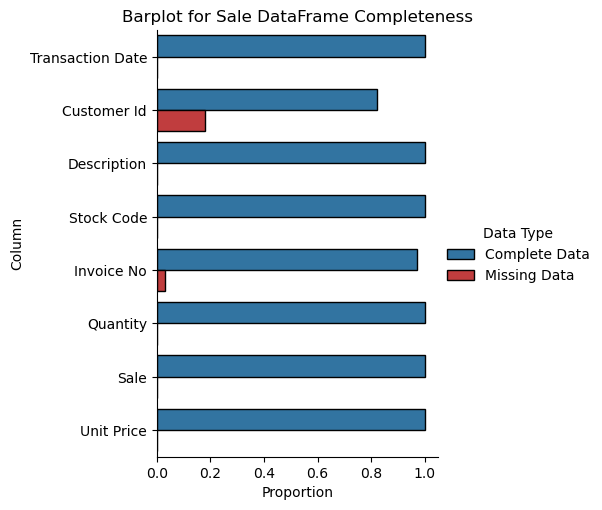

In [57]:
sale_df_columns = list(sale_df.columns)
plots.completeness_barplot(df=sale_df, columns=sale_df_columns, df_name="Sale")

El gráfico de barras de completitud confirma visualmente la presencia de valores nulos en las columnas customer_id (18% de datos faltantes) e invoice_no (3% de datos faltantes), lo que valida los hallazgos de la inspección inicial.

In [58]:
duplicated_rows = sale_df.duplicated(keep=False)
duplicated_rows_count = int(duplicated_rows.sum())
duplicated_rows_count

0

La verificación de duplicados en el dataframe sale_df confirmó que no hay registros duplicados.

          Column  Unique Values
transaction_date          11408
     customer_id           3146
     description             21
      stock_code             20
      invoice_no          11427
        quantity            108
            sale            610
      unit_price            101


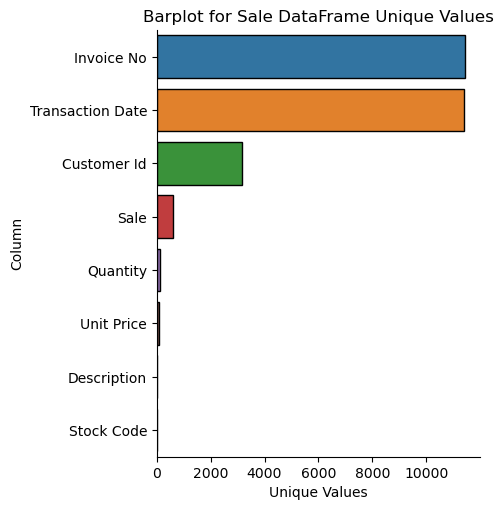

In [59]:
plots.uniqueness_barplot(df=sale_df, columns=sale_df_columns, df_name="Sale")

El gráfico de valores únicos confirma que las columnas invoice_no y transaction_date tienen la mayor cantidad de valores únicos, mientras que sale, quantity, unit_price, description y stock_code tienen un número considerablemente menor.

In [60]:
inconsistent_rows  = sale_df["unit_price"] <= 0
inconsistent_rows_count = int(inconsistent_rows.sum())
inconsistent_rows_count

63

In [61]:
sale_df[inconsistent_rows].head()

,transaction_date,customer_id,description,stock_code,invoice_no,quantity,sale,unit_price
538,12/7/2020 11:48,NaN,Indoor Pet Camera (Wi-Fi),22502,537534.0,5,0.0,0.0
762,12/9/2020 12:11,NaN,ChomChom Pet Hair Remover - Reusable Cat and D...,22114,538004.0,24,0.0,0.0
796,12/9/2020 14:10,NaN,Taste of the Wild High Prairie Grain-Free Dry ...,22423,538072.0,-2,0.0,0.0
1538,12/21/2020 13:45,14911.0,Taste of the Wild High Prairie Grain-Free Dry ...,22423,539722.0,2,0.0,0.0
1573,12/21/2020 15:40,NaN,ChomChom Pet Hair Remover - Reusable Cat and D...,22114,539750.0,1,0.0,0.0


In [62]:
inconsistent_rows  = sale_df["sale"] <= 0
inconsistent_rows_count = int(inconsistent_rows.sum())
inconsistent_rows_count

724

In [63]:
sale_df[inconsistent_rows].head()

,transaction_date,customer_id,description,stock_code,invoice_no,quantity,sale,unit_price
54,12/1/2020 12:38,17897.0,Rechargeable Pet Nail Grinder,22960,NaN,-1,-25.5,25.5
195,12/2/2020 17:27,15384.0,Sheba Perfect Portions Pat Wet Cat Food,22197,NaN,0,0.0,5.1
448,12/6/2020 12:55,14487.0,Taste of the Wild High Prairie Grain-Free Dry ...,22423,NaN,0,0.0,76.5
454,12/6/2020 13:17,16550.0,Sheba Perfect Portions Pat Wet Cat Food,22197,NaN,0,0.0,5.1
491,12/6/2020 15:09,16861.0,Litter Slide Multi-Cat Scented Clumping Clay C...,22086,NaN,-1,-17.7,17.7


In [64]:
inconsistent_rows  = sale_df["quantity"] <= 0
inconsistent_rows_count = int(inconsistent_rows.sum())
inconsistent_rows_count

677

In [65]:
sale_df[inconsistent_rows].head()

,transaction_date,customer_id,description,stock_code,invoice_no,quantity,sale,unit_price
54,12/1/2020 12:38,17897.0,Rechargeable Pet Nail Grinder,22960,NaN,-1,-25.5,25.5
195,12/2/2020 17:27,15384.0,Sheba Perfect Portions Pat Wet Cat Food,22197,NaN,0,0.0,5.1
448,12/6/2020 12:55,14487.0,Taste of the Wild High Prairie Grain-Free Dry ...,22423,NaN,0,0.0,76.5
454,12/6/2020 13:17,16550.0,Sheba Perfect Portions Pat Wet Cat Food,22197,NaN,0,0.0,5.1
491,12/6/2020 15:09,16861.0,Litter Slide Multi-Cat Scented Clumping Clay C...,22086,NaN,-1,-17.7,17.7


Se encontraron valores inconsistentes en el dataframe sale_df. Un total de 63 registros en la columna unit_price, 724 registros en sale y 677 registros en quantity tienen valores iguales o menores a cero, lo que requiere una limpieza profunda para asegurar la integridad de la información.

In [66]:
inconsistent_rows = inconsistent_rows = (((sale_df["unit_price"] * sale_df["quantity"]) != sale_df["sale"]) | (sale_df["quantity"] <= 0) | (sale_df["sale"] <= 0) | (sale_df["unit_price"] <= 0))
inconsistent_rows_count = int(inconsistent_rows.sum())
inconsistent_rows_count

1913

In [67]:
consistent_rows = ~inconsistent_rows
sale_df = sale_df[consistent_rows]
sale_df.head()

,transaction_date,customer_id,description,stock_code,invoice_no,quantity,sale,unit_price
0,12/1/2020 8:26,17850.0,Dog and Puppy Pads,85123A,536365.0,1,15.30,15.30
1,12/1/2020 8:34,13047.0,Pet Odor Eliminator,84879,536367.0,6,60.84,10.14
2,12/1/2020 8:34,13047.0,Rechargeable Pet Nail Grinder,22960,536368.0,1,25.50,25.50
4,12/1/2020 9:02,17850.0,Dog and Puppy Pads,85123A,536373.0,1,15.30,15.30
5,12/1/2020 9:32,15291.0,ChomChom Pet Hair Remover - Reusable Cat and D...,22114,536376.0,8,165.60,20.70


In [68]:
sale_df["invoice_no"] = sale_df["invoice_no"].fillna(-1).astype("int")

Dado que la columna invoice_no carece de una lógica para imputar los valores faltantes, se optó por una estrategia de etiquetado. Los valores nulos se reemplazaron con -1, lo que permite identificarlos fácilmente como registros sin número de factura y, al mismo tiempo, convierte la columna a un tipo de dato entero (int) para su análisis.

In [69]:
inconsistent_rows = sale_df["stock_code"].str.isdigit() == False
inconsistent_rows_count = int(inconsistent_rows.sum())
inconsistent_rows_count

4011

In [70]:
sale_df[inconsistent_rows].head()

,transaction_date,customer_id,description,stock_code,invoice_no,quantity,sale,unit_price
0,12/1/2020 8:26,17850.0,Dog and Puppy Pads,85123A,536365,1,15.3,15.3
4,12/1/2020 9:02,17850.0,Dog and Puppy Pads,85123A,536373,1,15.3,15.3
6,12/1/2020 9:32,17850.0,Dog and Puppy Pads,85123A,536375,1,15.3,15.3
12,12/1/2020 9:57,16029.0,Earth Rated Dog Poop Bags,85099B,536386,17,168.3,9.9
14,12/1/2020 10:19,17511.0,Dog and Puppy Pads,85123A,536390,11,168.3,15.3


In [71]:
sale_df["stock_code"] = sale_df["stock_code"].str.replace(r"\D", "", regex=True)
sale_df[inconsistent_rows].head()

,transaction_date,customer_id,description,stock_code,invoice_no,quantity,sale,unit_price
0,12/1/2020 8:26,17850.0,Dog and Puppy Pads,85123,536365,1,15.3,15.3
4,12/1/2020 9:02,17850.0,Dog and Puppy Pads,85123,536373,1,15.3,15.3
6,12/1/2020 9:32,17850.0,Dog and Puppy Pads,85123,536375,1,15.3,15.3
12,12/1/2020 9:57,16029.0,Earth Rated Dog Poop Bags,85099,536386,17,168.3,9.9
14,12/1/2020 10:19,17511.0,Dog and Puppy Pads,85123,536390,11,168.3,15.3


In [72]:
sale_df["stock_code"] = sale_df["stock_code"].astype("int")

Se identificaron y corrigieron los valores inconsistentes en la columna stock_code al eliminar las letras al final de los códigos. Esto aseguró la uniformidad de los datos, permitiendo que la columna se convirtiera al tipo de dato entero (int) para futuras operaciones y análisis numéricos.

In [73]:
sale_df["description"].unique()

array(['Dog and Puppy Pads', 'Pet Odor Eliminator',
       'Rechargeable Pet Nail Grinder',
       'ChomChom Pet Hair Remover - Reusable Cat and Dog Hair Remover',
       'Milk-Bone MaroSnacks Dog Treats with Real Bone',
       'Pet Grooming Brush',
       'Litter Slide Multi-Cat Scented Clumping Clay Cat Litter',
       'NexGard Chew for Dogs', 'Earth Rated Dog Poop Bags',
       'ProBiotic Supplements for Dogs',
       'Sheba Perfect Portions Pat Wet Cat Food',
       'Indoor Pet Camera (Wi-Fi)', 'Canned Cat Food',
       'Taste of the Wild High Prairie Grain-Free Dry Dog Food 40lb',
       'Memory Foam Pet Beds for Small, Medium, and Large Dogs and Cats',
       'UltraSound Dog Barking Deterrent', 'Indoor Pet Camera',
       'Pet Hair Remover', 'Purina Pro Plan Adult Sensitive Skin',
       'Purina ONE SmartBlend Natural Adult Chicken 10lb',
       'Templation Soft Cat Treats'], dtype=object)

In [74]:
sale_df["description"] = sale_df["description"].astype("category")
sale_df.rename(columns={"description":"sale_product_description"}, inplace=True)

La inspección de los valores únicos en la columna description no reveló inconsistencias. La columna se convirtió a tipo de dato category y se renombró de description a sale_product_description para asegurar que los datos estén listos para el análisis.

In [75]:
sale_df["customer_id"] = sale_df["customer_id"].fillna(-1).astype("int")

Se reemplazaron los valores nulos en la columna customer_id por -1. Esta estrategia de etiquetado permite la identificación de los registros sin un ID de cliente y asegura la conversión de la columna a un tipo de dato entero (int) para su correcto uso en futuros análisis.

In [76]:
sale_df["transaction_date"] = pd.to_datetime(sale_df["transaction_date"])

La columna transaction_date se convirtió a tipo de dato datetime. Esto es un paso crucial para habilitar análisis basados en el tiempo, como el estudio de tendencias, la estacionalidad y la frecuencia de las transacciones.

In [77]:
sale_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23152 entries, 0 to 25064
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   transaction_date          23152 non-null  datetime64[ns]
 1   customer_id               23152 non-null  int64         
 2   sale_product_description  23152 non-null  category      
 3   stock_code                23152 non-null  int64         
 4   invoice_no                23152 non-null  int64         
 5   quantity                  23152 non-null  int64         
 6   sale                      23152 non-null  float64       
 7   unit_price                23152 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(2), int64(4)
memory usage: 1.4 MB


In [78]:
duplicated_rows = sale_df.duplicated(keep=False)
duplicated_rows_count = int(duplicated_rows.sum())
duplicated_rows_count

0

El dataframe fue inspeccionado nuevamente tras la limpieza, lo que confirmó que todas las columnas tienen 25065 registros no nulos y que los tipos de datos son correctos. Adicionalmente, la verificación de duplicados no arrojó resultados, lo que confirma la singularidad de cada registro.

In [79]:
interim_data_path = data_interim_dir("sale.csv")
sale_df.to_csv(interim_data_path, index=False)